In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, Resize, ToPILImage
from dataset import SegmentationDataset
from models import VCN32, VCN16, VCN8
from train import VCNTrainer
import matplotlib.pyplot as plt
import pandas as pd
import evals
from IPython.display import display
import inference

# Semantic Segmentation with Fully Convolutional Networks
Semantic Segmentation is a task where you look at every pixel of an image and classify it in one of C categories. It's like coloring images in a coloring book. Green for grass. Blue for sky. Yellow for sun. So on and so forth. Training a neural net for semantic segmentation is a much more fancy way of saying "I'm going to teach an AI to be an expert at coloring within the lines." 



To do this task we'll use a fully convolutional network, a neural net that consists only of convolutional layers with ReLU activations and pooling layers mixed in.

## Config

In [5]:
BATCH_SIZE = 32
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
WEIGHT_DECAY = 5e-4
LR = 3e-4

## Dataset

In [6]:
torch.manual_seed(5)

In [7]:
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    Resize((224, 224), antialias=True)
])

target_transform = Compose([
    Resize((224, 224), antialias=True),
    lambda x: x[0] # first dimension is unnecessary
])

In [8]:
train_val_set = SegmentationDataset(root="data/stage1_train", train=True, transform=transform, target_transform=target_transform)
train_set, val_set = random_split(train_val_set, lengths=[0.8, 0.2]) # 80/20 split
test_set = SegmentationDataset(root="data/stage1_test", train=False)

In [9]:
print(f"train_set size: {len(train_set)}, val_set size: {len(val_set)}, test_set size: {len(test_set)}")

train_set size: 536, val_set size: 134, test_set size: 65


In [10]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
for (X, Y) in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 224, 224])


## Models
VCN32, VCN16, and VCN8

In [22]:
vcn32 = VCN32(pretrained=True, num_classes=NUM_CLASSES)
vcn16 = VCN16(pretrained=True, num_classes=NUM_CLASSES)
vcn8 = VCN8(pretrained=True, num_classes=NUM_CLASSES)

## Training

In [23]:
torch.cuda.empty_cache()

In [12]:
cross_entropy = torch.nn.CrossEntropyLoss()

In [13]:
vcn32_optimizer = torch.optim.Adam(vcn32.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
vcn16_optimizer = torch.optim.Adam(vcn16.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
vcn8_optimizer = torch.optim.Adam(vcn8.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [14]:
vcn32_trainer = VCNTrainer(
    model=vcn32,
    criterion=cross_entropy,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=vcn32_optimizer,
    epochs=EPOCHS,
    device=DEVICE,
    checkpoint="vcn32.pth"
)

In [15]:
vcn32_trainer.train()

Epoch [1/50]: Loss: 0.5995777757728801, Val Loss: 0.42112712264060975 Train Pixel Acc: 0.8392379718911819, Val Pixel Acc: 0.8408671625133263


Epoch [2/50]: Loss: 0.3740628116271075, Val Loss: 0.34203568696975706 Train Pixel Acc: 0.8606316586511004, Val Pixel Acc: 0.8625448867746726


Epoch [3/50]: Loss: 0.33103476289440603, Val Loss: 0.3028538584709167 Train Pixel Acc: 0.8608711886398682, Val Pixel Acc: 0.8627214295233019


Epoch [4/50]: Loss: 0.30753371382460876, Val Loss: 0.28608196675777436 Train Pixel Acc: 0.8643570899091912, Val Pixel Acc: 0.8663126689575084


Epoch [5/50]: Loss: 0.29580461452989015, Val Loss: 0.2821623235940933 Train Pixel Acc: 0.8670512259533011, Val Pixel Acc: 0.8696070429104478


Epoch [6/50]: Loss: 0.28561242012416616, Val Loss: 0.30585954785346986 Train Pixel Acc: 0.870118488889259, Val Pixel Acc: 0.872091134728145


Epoch [7/50]: Loss: 0.27711673869806175, Val Loss: 0.3019730031490326 Train Pixel Acc: 0.876183074384138, Val Pixel Acc: 0.8776552802790892


Epoch [8/50]: Loss: 0.27567315452239094, Val Loss: 0.27169098854064944 Train Pixel Acc: 0.8769540545637565, Val Pixel Acc: 0.8791869038893543


Epoch [9/50]: Loss: 0.2711062554050894, Val Loss: 0.2731661289930344 Train Pixel Acc: 0.8772582821899749, Val Pixel Acc: 0.8788547893504417


Epoch [10/50]: Loss: 0.26967381817453046, Val Loss: 0.27016519010066986 Train Pixel Acc: 0.8781650530431389, Val Pixel Acc: 0.8793000875723423


Epoch [11/50]: Loss: 0.26575573928215923, Val Loss: 0.2778165638446808 Train Pixel Acc: 0.879238847912066, Val Pixel Acc: 0.8800492415949589


Epoch [12/50]: Loss: 0.2706006397219265, Val Loss: 0.2663062155246735 Train Pixel Acc: 0.8792520477174078, Val Pixel Acc: 0.879799374857219


Epoch [13/50]: Loss: 0.2646300284301533, Val Loss: 0.2813663691282272 Train Pixel Acc: 0.879962234427353, Val Pixel Acc: 0.8806814936795614


Epoch [14/50]: Loss: 0.2674533304046182, Val Loss: 0.25536806881427765 Train Pixel Acc: 0.879238847912066, Val Pixel Acc: 0.8796881246668443


Epoch [15/50]: Loss: 0.26577599872561064, Val Loss: 0.2859681874513626 Train Pixel Acc: 0.8808748801234579, Val Pixel Acc: 0.881652255701721


Epoch [16/50]: Loss: 0.2631109050091575, Val Loss: 0.26002668738365176 Train Pixel Acc: 0.879592007774425, Val Pixel Acc: 0.8804412944048888


Epoch [17/50]: Loss: 0.2645109094241086, Val Loss: 0.2680013358592987 Train Pixel Acc: 0.8789589004911667, Val Pixel Acc: 0.8798261462934054


Epoch [18/50]: Loss: 0.26662852045367746, Val Loss: 0.27073569893836974 Train Pixel Acc: 0.8739781491537847, Val Pixel Acc: 0.875263252455833


Epoch [19/50]: Loss: 0.2683872598059037, Val Loss: 0.2866215169429779 Train Pixel Acc: 0.8777999575821467, Val Pixel Acc: 0.8788663903061225


Epoch [20/50]: Loss: 0.26673781871795654, Val Loss: 0.27423614263534546 Train Pixel Acc: 0.8778680388316707, Val Pixel Acc: 0.8782290813946847


Epoch [21/50]: Loss: 0.2638251220478731, Val Loss: 0.27217669486999513 Train Pixel Acc: 0.8807657493384481, Val Pixel Acc: 0.8811568354020712


Epoch [22/50]: Loss: 0.26541315545054045, Val Loss: 0.24938730597496034 Train Pixel Acc: 0.8774136680675069, Val Pixel Acc: 0.8789197844482942


Epoch [23/50]: Loss: 0.26532600557102876, Val Loss: 0.26452497243881223 Train Pixel Acc: 0.8808494100765306, Val Pixel Acc: 0.8809605115367042


Epoch [24/50]: Loss: 0.2631630555671804, Val Loss: 0.26022244691848756 Train Pixel Acc: 0.8818932729924992, Val Pixel Acc: 0.8824100360759976


Epoch [25/50]: Loss: 0.2625300857950659, Val Loss: 0.2660740911960602 Train Pixel Acc: 0.8817951854249162, Val Pixel Acc: 0.881765290654508


Epoch [26/50]: Loss: 0.2619923835291582, Val Loss: 0.277007395029068 Train Pixel Acc: 0.881205767638212, Val Pixel Acc: 0.8812544024139507


Epoch [27/50]: Loss: 0.26485076546669006, Val Loss: 0.2747116178274155 Train Pixel Acc: 0.8800342942097548, Val Pixel Acc: 0.8812454786018885


Epoch [28/50]: Loss: 0.26285044673611135, Val Loss: 0.25354662239551545 Train Pixel Acc: 0.8794385553895065, Val Pixel Acc: 0.8797264970587115


Epoch [29/50]: Loss: 0.26470067571191225, Val Loss: 0.2563083529472351 Train Pixel Acc: 0.8804214761056008, Val Pixel Acc: 0.8808141610188852


Epoch [30/50]: Loss: 0.26250526396667256, Val Loss: 0.2720133066177368 Train Pixel Acc: 0.8801871516738692, Val Pixel Acc: 0.880296282458879


Epoch [31/50]: Loss: 0.2607560175306657, Val Loss: 0.28288834989070893 Train Pixel Acc: 0.881825749481229, Val Pixel Acc: 0.8816184939460859


Epoch [32/50]: Loss: 0.26166857077794914, Val Loss: 0.24712921679019928 Train Pixel Acc: 0.8805306812557112, Val Pixel Acc: 0.8804180924935273


Epoch [33/50]: Loss: 0.2648695567074944, Val Loss: 0.2935052514076233 Train Pixel Acc: 0.87863195432674, Val Pixel Acc: 0.8792858094730429


Epoch [34/50]: Loss: 0.26370760623146505, Val Loss: 0.2815384387969971 Train Pixel Acc: 0.8816344824426973, Val Pixel Acc: 0.8819162518085593


Epoch [35/50]: Loss: 0.2613169813857359, Val Loss: 0.2792510181665421 Train Pixel Acc: 0.8814042852740444, Val Pixel Acc: 0.8812444374904813


Epoch [36/50]: Loss: 0.2593217439511243, Val Loss: 0.2710945338010788 Train Pixel Acc: 0.8813743161385357, Val Pixel Acc: 0.8812981290930552


Epoch [37/50]: Loss: 0.257431042544982, Val Loss: 0.26802889406681063 Train Pixel Acc: 0.8825394685334488, Val Pixel Acc: 0.8825587662770332


Epoch [38/50]: Loss: 0.25903430581092834, Val Loss: 0.2517589271068573 Train Pixel Acc: 0.8825468306784001, Val Pixel Acc: 0.8824635789483704


Epoch [39/50]: Loss: 0.25806554538362164, Val Loss: 0.30052870512008667 Train Pixel Acc: 0.8701908089495126, Val Pixel Acc: 0.8719099813432836


Epoch [40/50]: Loss: 0.26294273576315713, Val Loss: 0.27276513278484343 Train Pixel Acc: 0.8799214079871688, Val Pixel Acc: 0.8810256553647579


Epoch [41/50]: Loss: 0.25880877761279836, Val Loss: 0.2539644867181778 Train Pixel Acc: 0.8826363662594235, Val Pixel Acc: 0.882599667082318


Epoch [42/50]: Loss: 0.2586282053414513, Val Loss: 0.2692383795976639 Train Pixel Acc: 0.8808219321718893, Val Pixel Acc: 0.8816663850708194


Epoch [43/50]: Loss: 0.2601051733774297, Val Loss: 0.2537459284067154 Train Pixel Acc: 0.883258988063509, Val Pixel Acc: 0.8831487789845416


Epoch [44/50]: Loss: 0.256457937114379, Val Loss: 0.24946603178977966 Train Pixel Acc: 0.8830497990357523, Val Pixel Acc: 0.8826225715332775


Epoch [45/50]: Loss: 0.2554517449701534, Val Loss: 0.253945979475975 Train Pixel Acc: 0.8836112555446619, Val Pixel Acc: 0.8832472383776272


Epoch [46/50]: Loss: 0.2564266008489272, Val Loss: 0.2652766346931458 Train Pixel Acc: 0.8831690062918824, Val Pixel Acc: 0.882741406963905


Epoch [47/50]: Loss: 0.2621481471201953, Val Loss: 0.26597820222377777 Train Pixel Acc: 0.882880283789122, Val Pixel Acc: 0.8827403658524977


Epoch [48/50]: Loss: 0.2605157380594927, Val Loss: 0.2863243162631989 Train Pixel Acc: 0.8802662017757196, Val Pixel Acc: 0.880300000713905


Epoch [49/50]: Loss: 0.25822900410960703, Val Loss: 0.2509140491485596 Train Pixel Acc: 0.882065576930399, Val Pixel Acc: 0.8822595211125495


Epoch [50/50]: Loss: 0.2575162333600661, Val Loss: 0.27033878266811373 Train Pixel Acc: 0.8809535955823561, Val Pixel Acc: 0.880625571123972


In [15]:
vcn16_trainer = VCNTrainer(
    model=vcn16,
    criterion=cross_entropy,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=vcn16_optimizer,
    epochs=EPOCHS,
    device=DEVICE,
    checkpoint="vcn16.pth"
)

In [16]:
vcn16_trainer.train()

Epoch [1/50]: Loss: 0.6111002879984239, Val Loss: 0.4578848719596863 Train Pixel Acc: 0.7695045901114643, Val Pixel Acc: 0.7679649722528937


Epoch [2/50]: Loss: 0.34268929239581614, Val Loss: 0.2703412532806396 Train Pixel Acc: 0.8788599205423774, Val Pixel Acc: 0.8804578034572038


Epoch [3/50]: Loss: 0.2513396021197824, Val Loss: 0.23338566720485687 Train Pixel Acc: 0.8927884666868147, Val Pixel Acc: 0.8919405186281603


Epoch [4/50]: Loss: 0.2212157337104573, Val Loss: 0.202650985121727 Train Pixel Acc: 0.9039561341094273, Val Pixel Acc: 0.9023578793690984


Epoch [5/50]: Loss: 0.20067387205712936, Val Loss: 0.18846068680286407 Train Pixel Acc: 0.9093692069586696, Val Pixel Acc: 0.9084855636517667


Epoch [6/50]: Loss: 0.18738405669436736, Val Loss: 0.20312246084213256 Train Pixel Acc: 0.9158680474580224, Val Pixel Acc: 0.9133628731343284


Epoch [7/50]: Loss: 0.17832322856959174, Val Loss: 0.20309253334999083 Train Pixel Acc: 0.9181902836344426, Val Pixel Acc: 0.9154052362549497


Epoch [8/50]: Loss: 0.17259342091925003, Val Loss: 0.17151488065719606 Train Pixel Acc: 0.9207053113339553, Val Pixel Acc: 0.9178943848994822


Epoch [9/50]: Loss: 0.16893528489505544, Val Loss: 0.1788978934288025 Train Pixel Acc: 0.9205077232618794, Val Pixel Acc: 0.9173599972871611


Epoch [10/50]: Loss: 0.17033500618794384, Val Loss: 0.1717005968093872 Train Pixel Acc: 0.921762559968017, Val Pixel Acc: 0.9181494571942583


Epoch [11/50]: Loss: 0.16561267393476822, Val Loss: 0.175893896818161 Train Pixel Acc: 0.9219485842669624, Val Pixel Acc: 0.9191886351088943


Epoch [12/50]: Loss: 0.16555080957272472, Val Loss: 0.16420243680477142 Train Pixel Acc: 0.9248373709616776, Val Pixel Acc: 0.9216374778689461


Epoch [13/50]: Loss: 0.16077732031836228, Val Loss: 0.17497167140245437 Train Pixel Acc: 0.9257481575302696, Val Pixel Acc: 0.9220322078224946


Epoch [14/50]: Loss: 0.15986793663571863, Val Loss: 0.15463862419128419 Train Pixel Acc: 0.9277808160052734, Val Pixel Acc: 0.9242296965427962


Epoch [15/50]: Loss: 0.15552089933086843, Val Loss: 0.17580429017543792 Train Pixel Acc: 0.9289291990700198, Val Pixel Acc: 0.9258181350898569


Epoch [16/50]: Loss: 0.15211485633078745, Val Loss: 0.15005411356687545 Train Pixel Acc: 0.9317596463433788, Val Pixel Acc: 0.9280632174744898


Epoch [17/50]: Loss: 0.15009178922456853, Val Loss: 0.1570381909608841 Train Pixel Acc: 0.9247417374424116, Val Pixel Acc: 0.9214045663741243


Epoch [18/50]: Loss: 0.149695506428971, Val Loss: 0.15107765048742294 Train Pixel Acc: 0.9301400860017515, Val Pixel Acc: 0.926499170680399


Epoch [19/50]: Loss: 0.14422094033044927, Val Loss: 0.15528764426708222 Train Pixel Acc: 0.9329549537865519, Val Pixel Acc: 0.9289512855048736


Epoch [20/50]: Loss: 0.14167122849646738, Val Loss: 0.14338383376598357 Train Pixel Acc: 0.937795117901405, Val Pixel Acc: 0.9338726191269419


Epoch [21/50]: Loss: 0.13930248600595138, Val Loss: 0.15693189799785615 Train Pixel Acc: 0.9390492109565375, Val Pixel Acc: 0.9350675175620622


Epoch [22/50]: Loss: 0.13353278926190207, Val Loss: 0.12842537760734557 Train Pixel Acc: 0.9408493669447723, Val Pixel Acc: 0.9367605134404509


Epoch [23/50]: Loss: 0.13093601824606166, Val Loss: 0.1368608295917511 Train Pixel Acc: 0.9420908922979173, Val Pixel Acc: 0.9380387007881511


Epoch [24/50]: Loss: 0.13032588055905173, Val Loss: 0.136181977391243 Train Pixel Acc: 0.9394371365033887, Val Pixel Acc: 0.9356365593112245


Epoch [25/50]: Loss: 0.1316148875390782, Val Loss: 0.13055852353572844 Train Pixel Acc: 0.9438721967331709, Val Pixel Acc: 0.9403224530250534


Epoch [26/50]: Loss: 0.12730618873063257, Val Loss: 0.13631467074155806 Train Pixel Acc: 0.9449186996102079, Val Pixel Acc: 0.9410646167282212


Epoch [27/50]: Loss: 0.12291787783889209, Val Loss: 0.1294463261961937 Train Pixel Acc: 0.9462651169376333, Val Pixel Acc: 0.9424089890153823


Epoch [28/50]: Loss: 0.1243660454364384, Val Loss: 0.13715610057115554 Train Pixel Acc: 0.9408989684668176, Val Pixel Acc: 0.9367270491452178


Epoch [29/50]: Loss: 0.12822363613282933, Val Loss: 0.12559979259967805 Train Pixel Acc: 0.9445007677452978, Val Pixel Acc: 0.9403270636612854


Epoch [30/50]: Loss: 0.12259065754273359, Val Loss: 0.13121973127126693 Train Pixel Acc: 0.9467252881796375, Val Pixel Acc: 0.9427512172079653


Epoch [31/50]: Loss: 0.12093361510949976, Val Loss: 0.13374169915914536 Train Pixel Acc: 0.9476084481133872, Val Pixel Acc: 0.9437303081213829


Epoch [32/50]: Loss: 0.12169162271653905, Val Loss: 0.11195465251803398 Train Pixel Acc: 0.9466631561381549, Val Pixel Acc: 0.9428243924668748


Epoch [33/50]: Loss: 0.11916354999822729, Val Loss: 0.14000791758298875 Train Pixel Acc: 0.9473755366185653, Val Pixel Acc: 0.9436187604706061


Epoch [34/50]: Loss: 0.12007978646194234, Val Loss: 0.1366507202386856 Train Pixel Acc: 0.9483475256648835, Val Pixel Acc: 0.9444101538703168


Epoch [35/50]: Loss: 0.11990882280994863, Val Loss: 0.13344667553901673 Train Pixel Acc: 0.9476322077630026, Val Pixel Acc: 0.9437694241642552


Epoch [36/50]: Loss: 0.1189553496592185, Val Loss: 0.14765135049819947 Train Pixel Acc: 0.9422093559030422, Val Pixel Acc: 0.9376424835325922


Epoch [37/50]: Loss: 0.11993590961484348, Val Loss: 0.12762753218412398 Train Pixel Acc: 0.9486368430884481, Val Pixel Acc: 0.9446423217141334


Epoch [38/50]: Loss: 0.1166841216823634, Val Loss: 0.11824395805597306 Train Pixel Acc: 0.9459053757638783, Val Pixel Acc: 0.9419213026861865


Epoch [39/50]: Loss: 0.11717037856578827, Val Loss: 0.13151010274887084 Train Pixel Acc: 0.9489905606890611, Val Pixel Acc: 0.9451332801077521


Epoch [40/50]: Loss: 0.11908759439692777, Val Loss: 0.1313391163945198 Train Pixel Acc: 0.9469493130449474, Val Pixel Acc: 0.9431651333574474


Epoch [41/50]: Loss: 0.11784080459791071, Val Loss: 0.11678068041801452 Train Pixel Acc: 0.9479146464147693, Val Pixel Acc: 0.944168764754036


Epoch [42/50]: Loss: 0.11694401809397865, Val Loss: 0.13531197011470794 Train Pixel Acc: 0.9463105911965999, Val Pixel Acc: 0.9423239153403898


Epoch [43/50]: Loss: 0.11736114235485301, Val Loss: 0.11615613847970963 Train Pixel Acc: 0.9471489461572875, Val Pixel Acc: 0.9429374274196619


Epoch [44/50]: Loss: 0.11632003196898628, Val Loss: 0.11473029851913452 Train Pixel Acc: 0.9496992972795462, Val Pixel Acc: 0.9457021731267133


Epoch [45/50]: Loss: 0.11655755078091341, Val Loss: 0.12709921598434448 Train Pixel Acc: 0.9458630620216837, Val Pixel Acc: 0.9419678552391105


Epoch [46/50]: Loss: 0.12055186752010794, Val Loss: 0.12927841395139694 Train Pixel Acc: 0.9457119149548812, Val Pixel Acc: 0.9416631070571886


Epoch [47/50]: Loss: 0.11972789860823575, Val Loss: 0.1301477760076523 Train Pixel Acc: 0.9465666302376827, Val Pixel Acc: 0.9426987154469997


Epoch [48/50]: Loss: 0.11931668178123586, Val Loss: 0.14465299844741822 Train Pixel Acc: 0.9450023975308407, Val Pixel Acc: 0.9413790323732105


Epoch [49/50]: Loss: 0.1174154198345016, Val Loss: 0.1153539314866066 Train Pixel Acc: 0.9494033241794853, Val Pixel Acc: 0.9454930584640573


Epoch [50/50]: Loss: 0.11559470173190622, Val Loss: 0.11951607018709183 Train Pixel Acc: 0.9498701510979858, Val Pixel Acc: 0.9458479287237282


In [14]:
vcn8_trainer = VCNTrainer(
    model=vcn8,
    criterion=cross_entropy,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=vcn8_optimizer,
    epochs=EPOCHS,
    device=DEVICE,
    checkpoint="vcn8.pth"
)

In [ ]:
vcn8_trainer.train()

Epoch [1/50]: Loss: 0.634030983728521, Val Loss: 0.5426239013671875 Train Pixel Acc: 0.7366304191336049, Val Pixel Acc: 0.7354941947627932


Epoch [2/50]: Loss: 0.4372614516931422, Val Loss: 0.33021549582481385 Train Pixel Acc: 0.8475095648392286, Val Pixel Acc: 0.844463607504569


Epoch [3/50]: Loss: 0.27022936940193176, Val Loss: 0.22878174781799315 Train Pixel Acc: 0.8928872607228526, Val Pixel Acc: 0.8896756551267895


Epoch [4/50]: Loss: 0.19796228759429035, Val Loss: 0.17424654066562653 Train Pixel Acc: 0.9200325674521208, Val Pixel Acc: 0.9178030645560463


Epoch [5/50]: Loss: 0.16628255870412378, Val Loss: 0.14989244043827057 Train Pixel Acc: 0.9299951484208422, Val Pixel Acc: 0.9286118831861102


Epoch [6/50]: Loss: 0.14844557379975037, Val Loss: 0.15182829797267913 Train Pixel Acc: 0.9389317884628199, Val Pixel Acc: 0.9368970477650015


Epoch [7/50]: Loss: 0.13690950283232858, Val Loss: 0.14894015341997147 Train Pixel Acc: 0.9418545971910219, Val Pixel Acc: 0.9403809039940603


Epoch [8/50]: Loss: 0.1263954271288479, Val Loss: 0.12252689152956009 Train Pixel Acc: 0.94720100172765, Val Pixel Acc: 0.9457023218569144


Epoch [9/50]: Loss: 0.12108413918929942, Val Loss: 0.1209284245967865 Train Pixel Acc: 0.9499632190212839, Val Pixel Acc: 0.9487157444600974


Epoch [10/50]: Loss: 0.11431681846871096, Val Loss: 0.11157227754592895 Train Pixel Acc: 0.9516841018123667, Val Pixel Acc: 0.9508821485683826


Epoch [11/50]: Loss: 0.11213563864721972, Val Loss: 0.11346977204084396 Train Pixel Acc: 0.9524842331113882, Val Pixel Acc: 0.951944082203777


Epoch [12/50]: Loss: 0.10887329630991992, Val Loss: 0.10498742014169693 Train Pixel Acc: 0.954688637786038, Val Pixel Acc: 0.9533167132291349


Epoch [13/50]: Loss: 0.10500240106793012, Val Loss: 0.11220300197601318 Train Pixel Acc: 0.9556005026485874, Val Pixel Acc: 0.9543927762336277


Epoch [14/50]: Loss: 0.1047153709565892, Val Loss: 0.10103074163198471 Train Pixel Acc: 0.9542128870554751, Val Pixel Acc: 0.952674347490862


Epoch [15/50]: Loss: 0.10776735140996821, Val Loss: 0.12378252297639847 Train Pixel Acc: 0.9520333946894989, Val Pixel Acc: 0.9500859958022388


Epoch [16/50]: Loss: 0.10690251036601908, Val Loss: 0.10446956157684326 Train Pixel Acc: 0.9556574291330339, Val Pixel Acc: 0.9550937416711087


Epoch [17/50]: Loss: 0.1036278206635924, Val Loss: 0.09855061173439025 Train Pixel Acc: 0.9560697464328548, Val Pixel Acc: 0.9546087324855316


Epoch [18/50]: Loss: 0.10136363041751525, Val Loss: 0.09587967097759247 Train Pixel Acc: 0.9584004974132844, Val Pixel Acc: 0.9575223571238197


Epoch [19/50]: Loss: 0.09821278470404007, Val Loss: 0.09947824329137803 Train Pixel Acc: 0.958767080176287, Val Pixel Acc: 0.9574679218702407


Epoch [20/50]: Loss: 0.0977903565063196, Val Loss: 0.09743144065141678 Train Pixel Acc: 0.9588095798312328, Val Pixel Acc: 0.9578999831042492


Epoch [21/50]: Loss: 0.09915606063954971, Val Loss: 0.10606753528118133 Train Pixel Acc: 0.9592992368355925, Val Pixel Acc: 0.9579321088276729


Epoch [22/50]: Loss: 0.0975279895698323, Val Loss: 0.09287192448973655 Train Pixel Acc: 0.9577275676186986, Val Pixel Acc: 0.9561815543614834


Epoch [23/50]: Loss: 0.0969749325338532, Val Loss: 0.09675932824611663 Train Pixel Acc: 0.9596965323851089, Val Pixel Acc: 0.9584545980239111


Epoch [24/50]: Loss: 0.09669556381071315, Val Loss: 0.09471177607774735 Train Pixel Acc: 0.9589606897154851, Val Pixel Acc: 0.957653239700731


Epoch [25/50]: Loss: 0.09681756794452667, Val Loss: 0.0970100924372673 Train Pixel Acc: 0.9579440816088562, Val Pixel Acc: 0.9568200531145294


Epoch [26/50]: Loss: 0.09645324222305242, Val Loss: 0.09968879073858261 Train Pixel Acc: 0.9604056036185463, Val Pixel Acc: 0.9592494122182456


Epoch [27/50]: Loss: 0.09481921353760887, Val Loss: 0.09849879890680313 Train Pixel Acc: 0.9586067118370203, Val Pixel Acc: 0.9580540675925221


Epoch [28/50]: Loss: 0.09590837534736185, Val Loss: 0.10542826056480407 Train Pixel Acc: 0.953573644651424, Val Pixel Acc: 0.9514958093778556


Epoch [29/50]: Loss: 0.09682326939176111, Val Loss: 0.09077839255332946 Train Pixel Acc: 0.9604887438009252, Val Pixel Acc: 0.9592467350746269


Epoch [30/50]: Loss: 0.09370322174885694, Val Loss: 0.0987488642334938 Train Pixel Acc: 0.9607973217855239, Val Pixel Acc: 0.9596154372429943


Epoch [31/50]: Loss: 0.09380000172292485, Val Loss: 0.10151908844709397 Train Pixel Acc: 0.9608826557383681, Val Pixel Acc: 0.9596154372429943


Epoch [32/50]: Loss: 0.09458155272638097, Val Loss: 0.0850674569606781 Train Pixel Acc: 0.9609456429785067, Val Pixel Acc: 0.9603199722053001


Epoch [33/50]: Loss: 0.09442624055287417, Val Loss: 0.10971958786249161 Train Pixel Acc: 0.9604495162104021, Val Pixel Acc: 0.9593368655764545


Epoch [34/50]: Loss: 0.0950268393053728, Val Loss: 0.10376186817884445 Train Pixel Acc: 0.9605074094411552, Val Pixel Acc: 0.959877499857219


Epoch [35/50]: Loss: 0.09346580110928591, Val Loss: 0.10219775140285492 Train Pixel Acc: 0.9594836994674268, Val Pixel Acc: 0.9593713709830948


Epoch [36/50]: Loss: 0.09347579672056086, Val Loss: 0.09935732483863831 Train Pixel Acc: 0.9615967094335403, Val Pixel Acc: 0.9607370116890039


Epoch [37/50]: Loss: 0.09129259209422504, Val Loss: 0.09643123894929886 Train Pixel Acc: 0.9620893410419205, Val Pixel Acc: 0.9611696678438166


Epoch [38/50]: Loss: 0.09076580646283486, Val Loss: 0.08961896225810051 Train Pixel Acc: 0.9599966699307988, Val Pixel Acc: 0.958662969035562


Epoch [39/50]: Loss: 0.09110471365206382, Val Loss: 0.10868984758853913 Train Pixel Acc: 0.9590244206066288, Val Pixel Acc: 0.9580977942716266


Epoch [40/50]: Loss: 0.09118832121877109, Val Loss: 0.09352353513240814 Train Pixel Acc: 0.9625434887107828, Val Pixel Acc: 0.9615835839932988


Epoch [41/50]: Loss: 0.09043458717710831, Val Loss: 0.0849359929561615 Train Pixel Acc: 0.9627105499090961, Val Pixel Acc: 0.9617416841969997


Epoch [42/50]: Loss: 0.0917644342955421, Val Loss: 0.09776925146579743 Train Pixel Acc: 0.9629680018870888, Val Pixel Acc: 0.9622649170442431


Epoch [43/50]: Loss: 0.09019062624258153, Val Loss: 0.08756256848573685 Train Pixel Acc: 0.9609478739315223, Val Pixel Acc: 0.9597592593473957


Epoch [49/50]:  88%|████████▊ | 15/17 [02:26<00:19,  9.69s/it, summary=Loss: 0.06888018548488617, Val Loss: 0.08653964549303055]

## Evaluation

In [12]:
# load checkpoints
vcn32_checkpoint = torch.load("vcn32.pth", map_location=DEVICE)
vcn16_checkpoint = torch.load("vcn16.pth", map_location=DEVICE)
vcn8_checkpoint = torch.load("vcn8.pth", map_location=DEVICE)

In [13]:
iterations = vcn32_checkpoint["iterations"]
epochs = vcn32_checkpoint["epochs"]

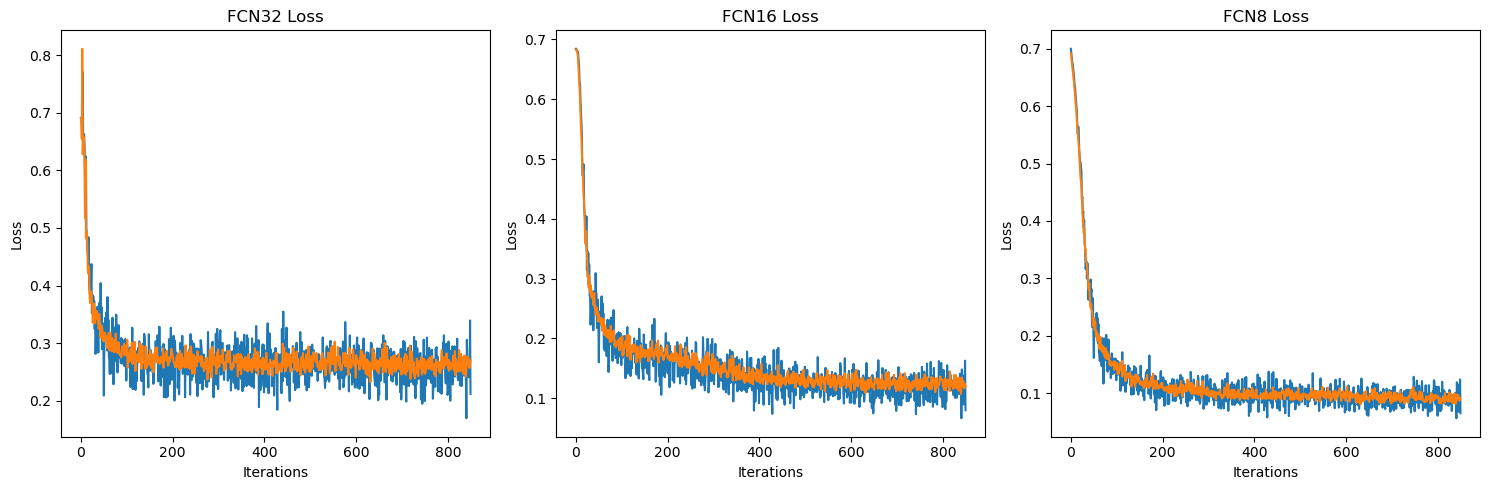

In [28]:
# display training losses vs. iterations
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

vcn32_train_losses = vcn32_checkpoint["train_losses"]
vcn32_val_losses = vcn32_checkpoint["val_losses"]

vcn16_train_losses = vcn16_checkpoint["train_losses"]
vcn16_val_losses = vcn16_checkpoint["val_losses"]

vcn8_train_losses = vcn8_checkpoint["train_losses"]
vcn8_val_losses = vcn8_checkpoint["val_losses"]

x = range(iterations)

models = ["FCN32", "FCN16", "FCN8"]
losses = [
    (vcn32_train_losses, vcn32_val_losses),
    (vcn16_train_losses, vcn16_val_losses),
    (vcn8_train_losses, vcn8_val_losses)
]

for i in range(3):
    model = models[i]
    train_losses, val_losses = losses[i]
    
    axes[i].plot(x, train_losses, label="train loss")
    axes[i].plot(x, val_losses, label="val loss")
    axes[i].set_title(model + " Loss")
    axes[i].set_ylabel("Loss")
    axes[i].set_xlabel("Iterations")

plt.tight_layout()  # Ensures proper spacing between subplots

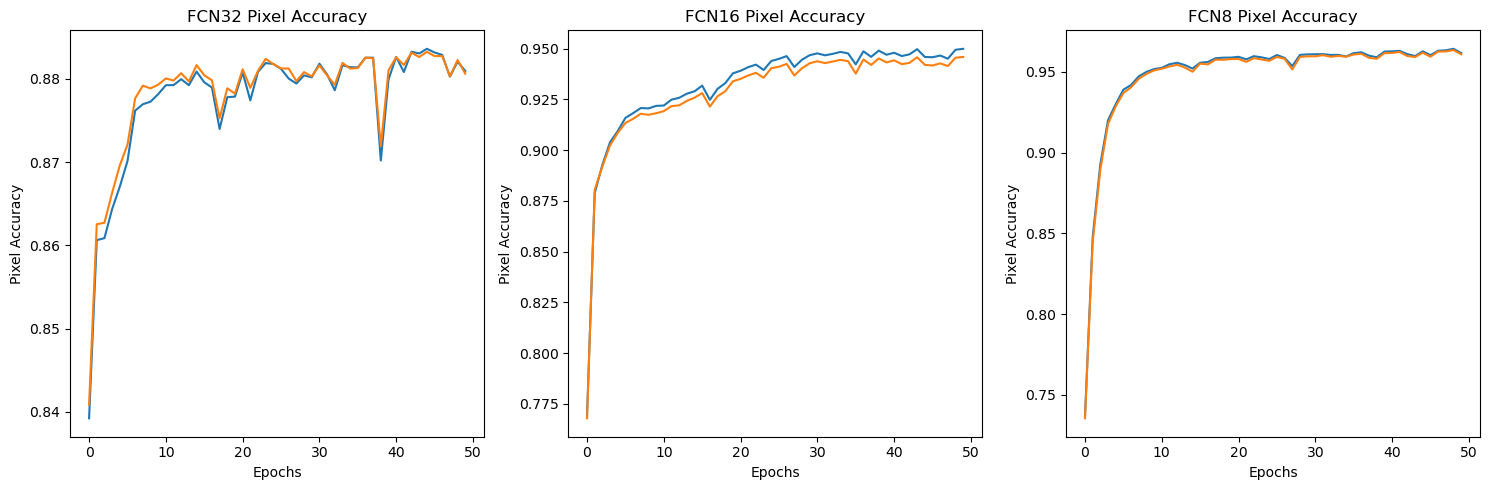

In [29]:
# display pixel accuracy vs. epochs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

vcn32_train_pix_acc = vcn32_checkpoint["train_pixel_accuracies"]
vcn32_val_pix_acc = vcn32_checkpoint["val_pixel_accuracies"]

vcn16_train_pix_acc = vcn16_checkpoint["train_pixel_accuracies"]
vcn16_val_pix_acc = vcn16_checkpoint["val_pixel_accuracies"]

vcn8_train_pix_acc = vcn8_checkpoint["train_pixel_accuracies"]
vcn8_val_pix_acc = vcn8_checkpoint["val_pixel_accuracies"]

x = range(epochs)

pix_acc = [
    (vcn32_train_pix_acc, vcn32_val_pix_acc),
    (vcn16_train_pix_acc, vcn16_val_pix_acc),
    (vcn8_train_pix_acc, vcn8_val_pix_acc)
]

for i in range(3):
    model = models[i]
    train_pix_acc, val_pix_acc = pix_acc[i]
    
    axes[i].plot(x, train_pix_acc, label="train pixel accuracy")
    axes[i].plot(x, val_pix_acc, label="val pixel accuracy")
    axes[i].set_title(model + " Pixel Accuracy")
    axes[i].set_ylabel("Pixel Accuracy")
    axes[i].set_xlabel("Epochs")

plt.tight_layout()  # Ensures proper spacing between subplots

In [27]:
# validation pixel accuracy, mean accuracy, mean IU, f.w. IU
vcn32.load_state_dict(vcn32_checkpoint["state_dict"])
vcn16.load_state_dict(vcn16_checkpoint["state_dict"])
vcn8.load_state_dict(vcn8_checkpoint["state_dict"])

def get_evals(model, dataloader):
    model.eval()
    model.to(DEVICE)
    pixel_accuracy = evals.pixel_accuracy(model, dataloader)
    mean_accuracy = evals.mean_accuracy(model, dataloader)
    mean_IU = evals.mean_IU(model, dataloader)
    frequency_weighted_IU = evals.frequency_weighted_IU(model, dataloader)

    return pixel_accuracy, mean_accuracy, mean_IU, frequency_weighted_IU

vcn32_evals = get_evals(vcn32, val_loader)
vcn16_evals = get_evals(vcn16, val_loader)
vcn8_evals = get_evals(vcn8, val_loader)

In [32]:
model_evals = [vcn32_evals, vcn16_evals, vcn8_evals]
data = [
    {
        "Pixel Accuracy": model_eval[0],
        "Mean Accuracy": model_eval[1],
        "Mean IU": model_eval[2],
        "Frequency Weighted IU": model_eval[3]
    }
    for model_eval in model_evals
]

indices = ["FCN32", "FCN16", "FCN8"]
evals_df = pd.DataFrame(data, index=indices)

evals_df

,Pixel Accuracy,Mean Accuracy,Mean IU,Frequency Weighted IU
FCN32,0.880626,0.681053,0.508039,0.038315
FCN16,0.945848,0.873729,0.864545,0.043082
FCN8,0.960866,0.888985,0.833553,0.043249


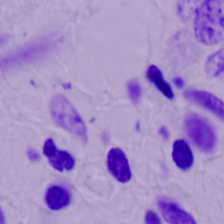

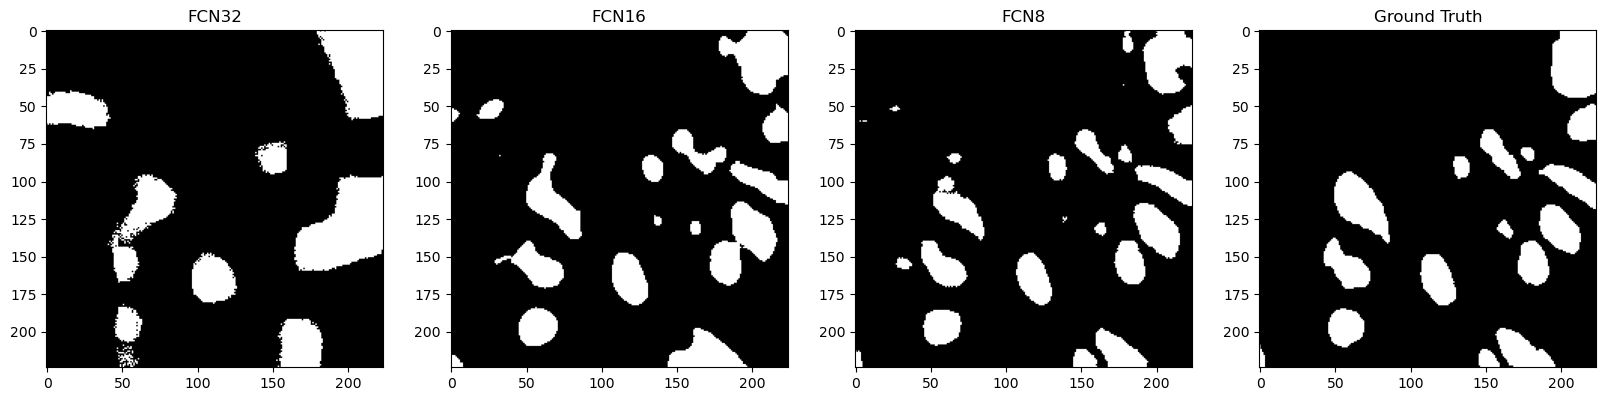

In [98]:
# visualize results vs. ground truth
i = 72

# 49
data = val_set[i]
img = data[0]
mask = data[1]

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the denormalization transform
denormalize = Compose([
    Normalize(
        mean=[-m / s for m, s in zip(mean, std)],  # Denormalize mean
        std=[1 / s for s in std]  # Denormalize standard deviation
    ),
    ToPILImage()  # Convert tensor back to PIL image
])

display(denormalize(img))
# plt.imshow(mask)

def get_mask(model, img):
    model = model.to(DEVICE)
    img = img.unsqueeze(0).to(DEVICE)
    result = model(img)
    mask = inference.get_mask(result).squeeze(0)
    
    return mask

fcn32_mask = get_mask(vcn32, img)
fcn16_mask = get_mask(vcn16, img)
fcn8_mask = get_mask(vcn8, img)

masks = [fcn32_mask, fcn16_mask, fcn8_mask, mask]
labels = ["FCN32", "FCN16", "FCN8", "Ground Truth"]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 3 columns

for i, ax in enumerate(axes):
    ax.set_title(labels[i])
    ax.imshow(masks[i].cpu(), cmap="gray")